## Import and installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers==4.28.0 datasets evaluate --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine =

In [ ]:
!pip install datasets
!pip install evaluate

In [ ]:
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 53.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.13.3
    Uninstalling tokenizers-0.13.3:
      Successfully uninstalled tokenizers-0.13.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.28.0
    Uninstalling transformers-4.28.0:
      Successfully uninstalled transformers-4.28.0


In [ ]:
from datasets import ClassLabel, Features, Dataset
from transformers import (BertTokenizer, BertForSequenceClassification,
                          Trainer, TrainingArguments,
                          DataCollatorWithPadding, TextClassificationPipeline)
import pandas as pd
from tqdm.auto import tqdm
import torch
import pickle
import numpy as np
import evaluate

In [ ]:
id2label = {n: tag for n, tag in enumerate([
    "lex",
    "ortho",
    "gov",
    "syntax",
    "asp",
    "prep",
    "constr",
    "ref",
    "agrcase",
    "conj",
    "punct",
    "agrgender",
    "agrnum",
    "num",
    "infl",
    "wo",
    "tense",
    "misspell",
    "brev",
    "gender",
    "deriv",
    "agrpers",
    "refl"
])}



label2id = {n : tag for tag, n in id2label.items()}

In [ ]:
label2id

{'lex': 0,
 'ortho': 1,
 'gov': 2,
 'syntax': 3,
 'asp': 4,
 'prep': 5,
 'constr': 6,
 'ref': 7,
 'agrcase': 8,
 'conj': 9,
 'punct': 10,
 'agrgender': 11,
 'agrnum': 12,
 'num': 13,
 'infl': 14,
 'wo': 15,
 'tense': 16,
 'misspell': 17,
 'brev': 18,
 'gender': 19,
 'deriv': 20,
 'agrpers': 21,
 'refl': 22}

In [ ]:
id2label

{0: 'lex',
 1: 'ortho',
 2: 'gov',
 3: 'syntax',
 4: 'asp',
 5: 'prep',
 6: 'constr',
 7: 'ref',
 8: 'agrcase',
 9: 'conj',
 10: 'punct',
 11: 'agrgender',
 12: 'agrnum',
 13: 'num',
 14: 'infl',
 15: 'wo',
 16: 'tense',
 17: 'misspell',
 18: 'brev',
 19: 'gender',
 20: 'deriv',
 21: 'agrpers',
 22: 'refl'}

## Preprocessing

In [ ]:
data = pd.read_csv('dataset_no_context.csv')
data

,text,tag
0,окружющей → окружающей,ortho
1,промышленным → промышленных,agrcase
2,воздействую → воздействуя,syntax
3,желудожно-кишечный → желудочно-кишечный,"ortho, altern"
4,это →,syntax
...,...,...
38920,Они → Им,gov
38921,были → было,agrnum
38922,[MASK] → у,prep
38923,[MASK] → них,ref


In [ ]:
data = data.dropna()

In [ ]:
def split_tags(row):
    tags = row['tag'].split(',')
    return pd.DataFrame({'text': row['text'], 'tag': tags})


data = pd.concat(data.apply(split_tags, axis=1).tolist(), ignore_index=True)
print(data)

                                          text      tag
0                       окружющей → окружающей    ortho
1                  промышленным → промышленных  agrcase
2                    воздействую → воздействуя   syntax
3      желудожно-кишечный → желудочно-кишечный    ortho
4      желудожно-кишечный → желудочно-кишечный   altern
...                                        ...      ...
45418                                 Они → Им      gov
45419                              были → было   agrnum
45420                               [MASK] → у     prep
45421                             [MASK] → них      ref
45422      в вуз экзаменами → экзаменами в вуз       wo

[45423 rows x 2 columns]


In [ ]:
tag_counts = data['tag'].value_counts()
tag_counts

,count
tag,
lex,7242
syntax,5602
ortho,4297
gov,2822
prep,1769
...,...
рецензией,1
insert,1
addw,1


delete tags with counts < 200

In [ ]:
data['tag'] = data['tag'].str.strip()

data['tag'] = data['tag'].str.lower()

tag_counts = data['tag'].value_counts()

data = data[data['tag'].map(tag_counts) >= 200]

tag_counts = data['tag'].value_counts()

print(tag_counts)

tag
lex          8140
syntax       5732
ortho        4643
gov          3426
constr       2859
prep         2214
ref          1890
asp          1487
conj         1406
agrcase      1291
agrnum       1163
wo           1109
agrgender    1092
num          1033
infl          974
punct         854
tense         601
space         553
misspell      418
brev          371
deriv         358
gender        328
refl          305
agrpers       297
hyphen        255
par           251
idiom         249
agrstr        245
aux           245
impers        222
Name: count, dtype: int64


In [ ]:
data['label'] = data['tag'].map(label2id)

<ipython-input-13-f78e78428c20>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['label'] = data['tag'].map(label2id)


In [ ]:
data

,text,tag,label
0,окружющей → окружающей,ortho,1.0
1,промышленным → промышленных,agrcase,8.0
2,воздействую → воздействуя,syntax,3.0
3,желудожно-кишечный → желудочно-кишечный,ortho,1.0
5,это →,syntax,3.0
...,...,...,...
45418,Они → Им,gov,2.0
45419,были → было,agrnum,12.0
45420,[MASK] → у,prep,5.0
45421,[MASK] → них,ref,7.0


In [ ]:
data = data.dropna()

In [ ]:
!pip install transformers datasets torch scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## Fine-tuning Roberta

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

class TextDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.texts = data['text'].values
        self.labels = data['label'].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long),
        }


class RobertaWithAttention(nn.Module):
    def __init__(self, num_labels):
        super(RobertaWithAttention, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.attention = nn.Sequential(
            nn.Linear(self.roberta.config.hidden_size, 1),
            nn.Tanh()
        )
        self.classifier = nn.Linear(self.roberta.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)

        # Attention mechanism
        attention_scores = self.attention(hidden_states).squeeze(-1)  # (batch_size, seq_len)
        attention_weights = torch.softmax(attention_scores, dim=1)  # (batch_size, seq_len)
        weighted_hidden_states = torch.sum(hidden_states * attention_weights.unsqueeze(-1), dim=1)

        # Classification
        logits = self.classifier(weighted_hidden_states)
        return logits


def train_and_evaluate(data, num_labels, num_epochs=10, batch_size=8, max_len=128, lr=2e-5, save_dir="saved_models"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используемое устройство: {device}")

    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
    dataset = TextDataset(data, tokenizer, max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


    model = RobertaWithAttention(num_labels=num_labels).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        correct_top3 = 0
        total_samples = 0
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        for batch in tqdm(dataloader, desc="Training", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            # Top-3 accuracy for the current batch
            top3_preds = torch.topk(logits, 3, dim=1).indices
            correct_top3 += sum([label in preds for label, preds in zip(labels.tolist(), top3_preds.tolist())])
            total_samples += labels.size(0)

        epoch_accuracy = correct_top3 / total_samples
        print(f"Loss: {epoch_loss / len(dataloader):.4f}, Top-3 Accuracy: {epoch_accuracy:.4f}")

        # Save the model after each epoch
        model_path = os.path.join(save_dir, f"model_5words_10_04_epoch_{epoch+1}.pth")
        torch.save(model.state_dict(), model_path)
        print(f"Model saved at {model_path}")

    return model

if __name__ == "__main__":

    data = data


    model = train_and_evaluate(data, num_labels=data['label'].nunique())

    MODEL_PATH = '/content/drive/MyDrive/models/trained_model_5words_10_04.pth'



    torch.save(model.state_dict(), MODEL_PATH)
    print(f"Модель сохранена в {MODEL_PATH}")


Используемое устройство: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/10


Loss: 1.6281, Top-3 Accuracy: 0.7420
Model saved at saved_models/model_5words_10_04_epoch_1.pth

Epoch 2/10


Loss: 1.3277, Top-3 Accuracy: 0.8227
Model saved at saved_models/model_5words_10_04_epoch_2.pth

Epoch 3/10


Loss: 1.2351, Top-3 Accuracy: 0.8443
Model saved at saved_models/model_5words_10_04_epoch_3.pth

Epoch 4/10


Loss: 1.1749, Top-3 Accuracy: 0.8583
Model saved at saved_models/model_5words_10_04_epoch_4.pth

Epoch 5/10


Loss: 1.1156, Top-3 Accuracy: 0.8719
Model saved at saved_models/model_5words_10_04_epoch_5.pth

Epoch 6/10


Loss: 1.0697, Top-3 Accuracy: 0.8825
Model saved at saved_models/model_5words_10_04_epoch_6.pth

Epoch 7/10


Loss: 1.0194, Top-3 Accuracy: 0.8938
Model saved at saved_models/model_5words_10_04_epoch_7.pth

Epoch 8/10


Loss: 0.9786, Top-3 Accuracy: 0.9031
Model saved at saved_models/model_5words_10_04_epoch_8.pth

Epoch 9/10


Loss: 0.9346, Top-3 Accuracy: 0.9111
Model saved at saved_models/model_5words_10_04_epoch_9.pth

Epoch 10/10


Loss: 0.8871, Top-3 Accuracy: 0.9227
Model saved at saved_models/model_5words_10_04_epoch_10.pth
Модель сохранена в /content/drive/MyDrive/models/trained_model_5words_10_04.pth


In [ ]:
# Save
torch.save(model.state_dict(), "trained_model_5words_10_04.pth")

## Testing on test data

In [ ]:
import torch
import pandas as pd
from transformers import RobertaTokenizer

MODEL_PATH = '/content/drive/MyDrive/models/trained_model_5words_10_04.pth'
TOKENIZER_PATH = "roberta-base"
OUTPUT_FILE = "rlc_test_no_context_llm_errant_marked.csv"


def load_model(model_path, num_labels):
    model = RobertaWithAttention(num_labels=num_labels)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model


def predict(model, tokenizer, text, max_len=128, top_k=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    encoding = tokenizer(
        text,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probabilities = torch.softmax(logits, dim=1).squeeze(0)


        top_probs, top_indices = torch.topk(probabilities, k=top_k)
        top_probs = top_probs.cpu().numpy()
        top_indices = top_indices.cpu().numpy()

    return top_indices, top_probs


if __name__ == "__main__":

    allowed_tags = [
        "lex",
        "ortho",
        "gov",
        "syntax",
        "asp",
        "prep",
        "constr",
        "ref",
        "agrcase",
        "conj",
        "punct",
        "agrgender",
        "agrnum",
        "num",
        "infl",
        "wo",
        "tense",
        "misspell",
        "brev",
        "gender",
        "deriv",
        "agrpers",
        "refl"
    ]

    id2label = {n: tag for n, tag in enumerate(allowed_tags)}  # Use allowed_tags

    num_labels = len(allowed_tags) # Set num_labels based on the length of allowed_tags


    input_file = "rlc_test_no_context_llm_errant.csv"
    data = pd.read_csv(input_file)
    data['tag'] = data['tag'].str.lower()  # Ensure tags are lowercase for comparison
    data = data.dropna()

    # Filter out rows where the 'tag' is not in 'allowed_tags'
    data = data[data['tag'].isin(allowed_tags)]

    tokenizer = RobertaTokenizer.from_pretrained(TOKENIZER_PATH)
    model = load_model(MODEL_PATH, num_labels)


    predictions = []
    for text in data["text"]:
        top_indices, top_probs = predict(model, tokenizer, text, top_k=3)
        top_labels = [id2label[idx] for idx in top_indices]
        predictions.append(", ".join([f"{label} ({prob:.4f})" for label, prob in zip(top_labels, top_probs)]))

    data["top_3_predictions"] = predictions

    data.to_csv(OUTPUT_FILE, index=False)
    print(f"Результаты сохранены в файл: {OUTPUT_FILE}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Результаты сохранены в файл: rlc_test_no_context_llm_errant_marked.csv


In [ ]:
data

,text,tag,top_3_predictions
0,"прийдти -> прийти | не смогу прийдти , так -> ...",ortho,"ortho (0.7324), misspell (0.1377), lex (0.0957)"
1,делать курсы -> делать задания | что буду дела...,lex,"constr (0.5809), lex (0.3702), syntax (0.0364)"
2,сожелению -> сожалению | К сожелению я буду ->...,ortho,"ortho (0.9679), lex (0.0248), misspell (0.0023)"
3,болезьни -> болезни | по поводу болезьни . -> ...,ortho,"ortho (0.7777), infl (0.1034), deriv (0.0606)"
4,по поводу -> из-за | от занятия по поводу боле...,gov,"prep (0.7972), syntax (0.0742), lex (0.0645)"
...,...,...,...
26268,трудного дня -> трудном дне | расскажет о труд...,gov,"gov (0.7364), agrcase (0.1355), constr (0.0784)"
26269,"кого -> которой | , у кого всё не -> , у котор...",ref,"ref (0.7697), lex (0.0795), conj (0.0579)"
26270,для читателя -> читателю | то есть для читател...,gov,"gov (0.3819), prep (0.3328), constr (0.1683)"
26271,знать -> узнать | читателя трудно знать всё де...,asp,"asp (0.8896), lex (0.0708), syntax (0.0273)"


## Confusion matrix

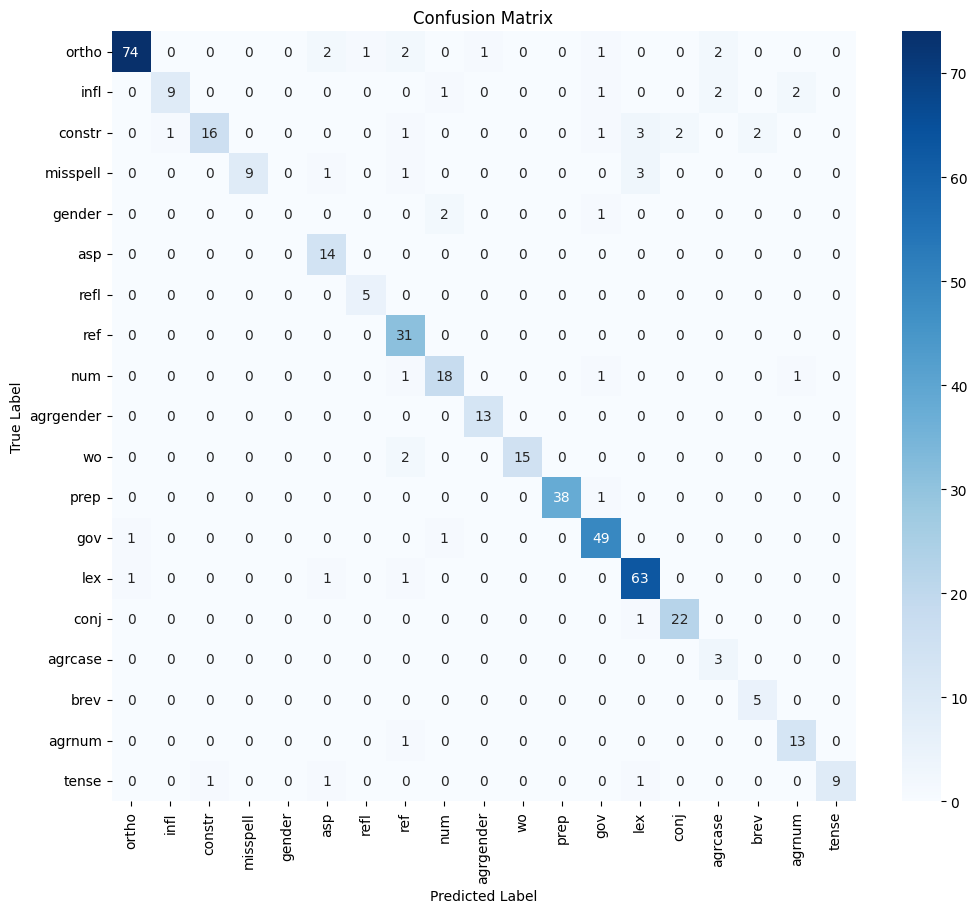

Classification Metrics:
              precision    recall  f1-score     support
agrcase        0.428571  1.000000  0.600000    3.000000
agrgender      0.928571  0.928571  0.928571   14.000000
agrnum         0.812500  0.928571  0.866667   14.000000
asp            0.736842  1.000000  0.848485   14.000000
brev           0.714286  1.000000  0.833333    5.000000
conj           0.916667  0.956522  0.936170   23.000000
constr         0.941176  0.470588  0.627451   34.000000
deriv          0.000000  0.000000  0.000000    0.000000
gender         0.000000  0.000000  0.000000    3.000000
gov            0.890909  0.960784  0.924528   51.000000
infl           0.900000  0.600000  0.720000   15.000000
lex            0.887324  0.940299  0.913043   67.000000
misspell       1.000000  0.600000  0.750000   15.000000
num            0.818182  0.857143  0.837209   21.000000
ortho          0.973684  0.880952  0.925000   84.000000
prep           1.000000  0.974359  0.987013   39.000000
ref            0.775000 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

In [ ]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("rlc_test_no_context_llm_errant_marked.csv")

def extract_predicted_tag(row):
    true_tag = row['tag']
    top_3_predictions = row['top_3_predictions'].split(", ")

    for prediction in top_3_predictions:
        predicted_tag = prediction.split(" ")[0]
        if predicted_tag == true_tag:
            return predicted_tag

    return top_3_predictions[0].split(" ")[0]


data["predicted_tag"] = data.apply(extract_predicted_tag, axis=1)


true_labels = data["tag"]
predicted_labels = data["predicted_tag"]

# confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=true_labels.unique())
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=true_labels.unique(), yticklabels=true_labels.unique(), cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


report = classification_report(true_labels, predicted_labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print("Classification Metrics:")
print(report_df)


report_df.to_csv("classification_report.csv", index=True)